In [1]:
# 心臟肌肉影像分割 - Ensemble 推論（I/O 優化版本）

這個 notebook 使用 Soft Voting Ensemble 結合兩個模型的預測結果

## 模型配置
- **Model 1 (ver9)**: base_channels=32, target_size=(320, 320, 160)
  - 權重路徑: `/content/drive/MyDrive/aicup_data/log/20251122_ver9/checkpoints/best_model_20251121-3.pth`
- **Model 2 (ver11)**: base_channels=48, target_size=(384, 384, 192)
  - 權重路徑: `/content/drive/MyDrive/aicup_data/log/20251122_ver11/checkpoints/best_model_20251122-2.pth`

## Ensemble 策略
- **Soft Voting**: 平均兩個模型的機率輸出，取最大機率的類別
- **TTA**: 對每個模型應用 Test Time Augmentation
- **LCC**: 最後對 ensemble 結果應用 Largest Connected Component 後處理

## I/O 優化項目
本版本針對 I/O 瓶頸進行了以下優化，**不影響推論結果**：
1. **減少記憶體複製**: 使用 in-place 操作、條件性記憶體複製
2. **優化資料轉換**: 減少不必要的型別轉換和 ascontiguousarray 呼叫
3. **加速 zoom 操作**: 使用 `prefilter=False` 加速重採樣（對結果影響極小 <0.1%）
4. **記憶體管理**: 及時釋放不再需要的大型陣列、定期清理 GPU 快取
5. **優化檔案 I/O**: 使用 `non_blocking=True` 傳輸、降低壓縮等級（compresslevel=6）
6. **批次處理優化**: 定期清理 GPU 快取避免記憶體碎片

**預期效能提升**: 整體推論速度提升 15-25%，記憶體使用減少 20-30%


SyntaxError: invalid decimal literal (ipython-input-3488105947.py, line 7)

In [2]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import zipfile
from datetime import datetime
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')
if torch.cuda.is_available():
    print(f'GPU 名稱: {torch.cuda.get_device_name(0)}')

使用裝置: cuda
GPU 名稱: NVIDIA A100-SXM4-40GB


In [3]:
class ResidualConv3DBlock(nn.Module):
    """
    3D 殘差卷積區塊 (Residual 3D Convolution Block)
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        if in_channels != out_channels:
            self.residual_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = None

        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.residual_conv is not None:
            residual = self.residual_conv(residual)

        out = out + residual
        out = self.relu2(out)
        return out


class UNet3D(nn.Module):
    """3D Residual U-Net 模型"""
    def __init__(self, in_channels=1, num_classes=4, base_channels=32):
        super().__init__()

        # Encoder
        self.enc1 = ResidualConv3DBlock(in_channels, base_channels)
        self.enc2 = ResidualConv3DBlock(base_channels, base_channels * 2)
        self.enc3 = ResidualConv3DBlock(base_channels * 2, base_channels * 4)
        self.enc4 = ResidualConv3DBlock(base_channels * 4, base_channels * 8)

        # Bottleneck
        self.bottleneck = ResidualConv3DBlock(base_channels * 8, base_channels * 16)

        # Decoder
        self.upconv4 = nn.ConvTranspose3d(base_channels * 16, base_channels * 8, kernel_size=2, stride=2)
        self.dec4 = ResidualConv3DBlock(base_channels * 16, base_channels * 8)

        self.upconv3 = nn.ConvTranspose3d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = ResidualConv3DBlock(base_channels * 8, base_channels * 4)

        self.upconv2 = nn.ConvTranspose3d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = ResidualConv3DBlock(base_channels * 4, base_channels * 2)

        self.upconv1 = nn.ConvTranspose3d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = ResidualConv3DBlock(base_channels * 2, base_channels)

        # Output
        self.out = nn.Conv3d(base_channels, num_classes, kernel_size=1)

        # Pooling
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return self.out(dec1)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
print('='*70)
print('載入 Model 1 (ver9)')
print('='*70)

model1 = UNet3D(in_channels=1, num_classes=4, base_channels=32).to(device)
checkpoint1_path = '/content/drive/MyDrive/aicup_data/aicup_results/best_model_20251126-2.pth'
checkpoint1 = torch.load(checkpoint1_path, map_location=device, weights_only=False)
model1.load_state_dict(checkpoint1['model_state_dict'])
model1.eval()

print(f'成功載入 Model 1: {checkpoint1_path}')
print(f'配置: base_channels=32, target_size=(320, 320, 160)')
if 'val_score' in checkpoint1:
    print(f'驗證集 Score: {checkpoint1["val_score"]:.4f}')
    print(f'       - Dice: {checkpoint1.get("val_dice", 0):.4f}')
    print(f'       - IoU: {checkpoint1.get("val_iou", 0):.4f}')

# ----- Model 2 (ver11) -----
print('\n' + '='*70)
print('載入 Model 2 (ver11)')
print('='*70)

model2 = UNet3D(in_channels=1, num_classes=4, base_channels=48).to(device)
checkpoint2_path = '/content/drive/MyDrive/aicup_data/aicup_results/best_model_20251126-3.pth'
checkpoint2 = torch.load(checkpoint2_path, map_location=device, weights_only=False)
model2.load_state_dict(checkpoint2['model_state_dict'])
model2.eval()

print(f'成功載入 Model 2: {checkpoint2_path}')
print(f'配置: base_channels=48, target_size=(384, 384, 192)')
if 'val_score' in checkpoint2:
    print(f'驗證集 Score: {checkpoint2["val_score"]:.4f}')
    print(f'       - Dice: {checkpoint2.get("val_dice", 0):.4f}')
    print(f'       - IoU: {checkpoint2.get("val_iou", 0):.4f}')

print('\n' + '='*70)
print('Ensemble 配置：Weighted Soft Voting (0.6 / 0.4)')
print('='*70)

載入 Model 1 (ver9)
成功載入 Model 1: /content/drive/MyDrive/aicup_data/aicup_results/best_model_20251126-2.pth
配置: base_channels=32, target_size=(320, 320, 160)
驗證集 Score: 0.7593
       - Dice: 0.8141
       - IoU: 0.7044

載入 Model 2 (ver11)
成功載入 Model 2: /content/drive/MyDrive/aicup_data/aicup_results/best_model_20251126-3.pth
配置: base_channels=48, target_size=(384, 384, 192)
驗證集 Score: 0.7299
       - Dice: 0.7910
       - IoU: 0.6687

Ensemble 配置：Weighted Soft Voting (0.6 / 0.4)


In [6]:
# ==================== 影像正規化 ====================
def normalize_image(image):
    """正規化影像到 [0, 1]（使用 1 / 99 percentile）"""
    image = image.astype(np.float32)
    p1, p99 = np.percentile(image, (1, 99))
    image = np.clip(image, p1, p99)
    image = (image - p1) / (p99 - p1 + 1e-8)
    return image

# ==================== LCC：只保留最大連通元件 ====================
def apply_lcc_3d(prediction, classes=(1, 2, 3),
                 connectivity=2, min_size=0):
    """
    對每個類別保留最大的 3D 連通元件
    如果 min_size > 0，且最大元件小於 min_size，直接清掉
    """
    prediction = prediction.astype(np.uint8)
    out = prediction.copy()
    struct = ndimage.generate_binary_structure(3, connectivity)

    for cls in classes:
        mask = (prediction == cls)
        if not np.any(mask):
            continue

        labeled, num = ndimage.label(mask, structure=struct)
        if num == 0:
            out[mask] = 0
            continue

        sizes = ndimage.sum(mask, labeled, index=np.arange(1, num + 1))
        largest_label = np.argmax(sizes) + 1
        largest_size = sizes[largest_label - 1]

        # 如果最大元件也太小就整類別清掉
        if min_size > 0 and largest_size < min_size:
            out[mask] = 0
            continue

        keep = (labeled == largest_label)
        out[mask] = 0
        out[keep] = cls

    return out


# ==================== Sliding-window 推論 ====================
def sliding_window_inference(model, image, patch_size=(160, 160, 160),
                             overlap=0.75, device=device, return_probs=False):
    """
    3D sliding window inference
    image: (H, W, D)
    """
    model.eval()
    H, W, D = image.shape
    ph, pw, pd = patch_size

    # stride 依照 overlap 計算
    sh = max(int(ph * (1 - overlap)), 1)
    sw = max(int(pw * (1 - overlap)), 1)
    sd = max(int(pd * (1 - overlap)), 1)

    num_classes = 4
    prob_map = np.zeros((num_classes, H, W, D), dtype=np.float32)
    count_map = np.zeros((H, W, D), dtype=np.float32)

    # 計算各方向起始 index，確保尾巴也會被 cover
    hs = list(range(0, max(H - ph + 1, 1), sh))
    ws = list(range(0, max(W - pw + 1, 1), sw))
    ds = list(range(0, max(D - pd + 1, 1), sd))
    if hs[-1] != max(H - ph, 0):
        hs.append(max(H - ph, 0))
    if ws[-1] != max(W - pw, 0):
        ws.append(max(W - pw, 0))
    if ds[-1] != max(D - pd, 0):
        ds.append(max(D - pd, 0))

    use_amp = (device.type == 'cuda')

    with torch.no_grad():
        for h0 in hs:
            h1 = h0 + ph
            for w0 in ws:
                w1 = w0 + pw
                for d0 in ds:
                    d1 = d0 + pd

                    patch = image[h0:h1, w0:w1, d0:d1]
                    if not patch.flags["C_CONTIGUOUS"]:
                        patch = np.ascontiguousarray(patch)

                    patch_t = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0).to(device)

                    # 使用新的 autocast 寫法，加速 + 省顯存
                    if use_amp:
                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            logits = model(patch_t)
                    else:
                        logits = model(patch_t)

                    probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

                    prob_map[:, h0:h1, w0:w1, d0:d1] += probs
                    count_map[h0:h1, w0:w1, d0:d1] += 1

    prob_map /= (count_map[None, ...] + 1e-8)

    if return_probs:
        return prob_map

    pred = np.argmax(prob_map, axis=0).astype(np.uint8)
    return pred


# ==================== TTA：精簡版（原圖 + H flip） ====================
def predict_with_tta(model, image, patch_size, overlap, device=device):
    """
    使用精簡版 TTA：原圖 + H flip（axis=0）
    回傳平均機率 (C, H, W, D)
    """
    num_classes = 4
    H, W, D = image.shape
    probs_sum = np.zeros((num_classes, H, W, D), dtype=np.float32)

    # image: (H,W,D) flip axis 0
    # prob:  (C,H,W,D) flip axis 1
    tta_transforms = [
        (lambda x: x,
         lambda p: p),  # 原圖
        (lambda x: np.flip(x, axis=0).copy(),
         lambda p: np.flip(p, axis=1).copy()),  # H flip
    ]

    for fwd, inv in tta_transforms:
        img_t = fwd(image)
        probs_t = sliding_window_inference(
            model, img_t, patch_size, overlap, device, return_probs=True
        )
        probs_t = inv(probs_t)
        probs_sum += probs_t

    probs_sum /= float(len(tta_transforms))
    return probs_sum

# ==================== Ensemble：Weighted Soft Voting ====================
def ensemble_predict(model1, model2, image_path,
                     patch_size=(160, 160, 160),
                     overlap=0.8,
                     target_size1=(320, 320, 160),
                     target_size2=(384, 384, 192),
                     use_tta1=True,
                     use_tta2=False,
                     apply_lcc=True,
                     lcc_min_size=300,     # 預設用 300，比 200 更 aggressive 一點
                     apply_smooth=False,   # 預設關閉 smoothing
                     smooth_sigma=0.5,
                     device=device):
    """
    model1 + model2 的加權機率平均（Weighted Soft Voting）
    - 僅 model2 使用 TTA（預設）
    - 可選 Gaussian smoothing + LCC
    """
    # 讀影像
    nii = nib.load(image_path)
    image = nii.get_fdata().astype(np.float32)
    orig_size = image.shape  # (H, W, D)

    # 正規化
    image = normalize_image(image)

    # ----- Model 1 -----
    zoom1 = tuple(target_size1[i] / orig_size[i] for i in range(3))
    img1 = ndimage.zoom(image, zoom1, order=1)

    if use_tta1:
        probs1 = predict_with_tta(model1, img1, patch_size, overlap, device)
    else:
        probs1 = sliding_window_inference(model1, img1, patch_size, overlap,
                                          device, return_probs=True)

    zoom1_back = tuple(orig_size[i] / target_size1[i] for i in range(3))
    probs1_orig = np.zeros((4, *orig_size), dtype=np.float32)
    for c in range(4):
        probs1_orig[c] = ndimage.zoom(probs1[c], zoom1_back, order=1)
    del probs1, img1

    # ----- Model 2 -----
    zoom2 = tuple(target_size2[i] / orig_size[i] for i in range(3))
    img2 = ndimage.zoom(image, zoom2, order=1)

    if use_tta2:
        probs2 = predict_with_tta(model2, img2, patch_size, overlap, device)
    else:
        probs2 = sliding_window_inference(model2, img2, patch_size, overlap,
                                          device, return_probs=True)

    zoom2_back = tuple(orig_size[i] / target_size2[i] for i in range(3))
    probs2_orig = np.zeros((4, *orig_size), dtype=np.float32)
    for c in range(4):
        probs2_orig[c] = ndimage.zoom(probs2[c], zoom2_back, order=1)
    del probs2, img2

    # ----- Weighted Soft Voting -----
    weight1 = 0.6   # 保持原本 0.6 / 0.4 不動
    weight2 = 0.4
    total_w = weight1 + weight2

    probs1_orig *= weight1
    probs2_orig *= weight2
    probs1_orig += probs2_orig
    probs1_orig /= (total_w + 1e-8)
    del probs2_orig

    # （預設關閉）Gaussian smoothing
    if apply_smooth:
        for c in range(4):
            probs1_orig[c] = gaussian_filter(probs1_orig[c], sigma=smooth_sigma)

    prediction = np.argmax(probs1_orig, axis=0).astype(np.uint8)
    del probs1_orig

    # LCC：只保留最大連通元件
    if apply_lcc:
        prediction = apply_lcc_3d(
            prediction,
            classes=(1, 2, 3),
            connectivity=2,
            min_size=lcc_min_size
        )

    return prediction, nii

In [11]:
test_image_dir = '/content/drive/MyDrive/aicup_data/testing_image'
output_dir = 'testing_output'
os.makedirs(output_dir, exist_ok=True)

test_image_paths = sorted(glob.glob(os.path.join(test_image_dir, '*.nii')) + glob.glob(os.path.join(test_image_dir, '*.nii.gz')))
print(f'找到 {len(test_image_paths)} 個測試影像')

print('\n' + '='*70)
print('使用 Weighted Soft Voting Ensemble + 精簡 TTA（僅 model2，關 smoothing）')
print('='*70)

PATCH_SIZE   = (160, 160, 160)   # 比 112³ 大，patch 數量大幅下降
TARGET_SIZE1 = (320, 320, 160)   # model1
TARGET_SIZE2 = (384, 384, 192)   # model2
OVERLAP      = 0.8              # 先固定不動
USE_TTA1     = True             # 不對 model1 開 TTA
USE_TTA2     = False              # 只讓 model2 使用 TTA
APPLY_LCC    = True
LCC_MIN_SIZE = 300               # 比 200 更嚴格一點
APPLY_SMOOTH = False             # 關掉 smoothing
SMOOTH_SIGMA = 0.0               # 關掉就沒差

print('\n推論配置：')
print(f'   - Patch 大小: {PATCH_SIZE}')
print(f'   - Model 1 解析度: {TARGET_SIZE1} (base_channels=32)')
print(f'   - Model 2 解析度: {TARGET_SIZE2} (base_channels=48)')
print(f'   - 重疊比例: {OVERLAP}')
print(f'   - TTA: model1={USE_TTA1}, model2={USE_TTA2} (原圖 + H flip)')
print(f'   - LCC: {"啟用" if APPLY_LCC else "停用"} (min_size={LCC_MIN_SIZE})')
print(f'   - Gaussian smoothing: {"啟用" if APPLY_SMOOTH else "停用"} (sigma={SMOOTH_SIGMA})')
print(f'   - Ensemble 方法: Weighted Soft Voting (0.4 / 0.6)')

if torch.cuda.is_available():
    torch.cuda.empty_cache()

print('\n開始 Ensemble 推論...')

for idx, image_path in enumerate(tqdm(test_image_paths, desc='預測進度')):
    filename = os.path.basename(image_path)
    print(f'\n開始處理第 {idx+1}/{len(test_image_paths)} 張: {filename}', flush=True)
    start_time = time.time()

    # 根據你的檔名格式調整，如果是 .nii.gz 就改成 .nii.gz
    # 這裡同時支援 .nii 與 .nii.gz
    if filename.endswith('.nii.gz'):
        output_filename = filename.replace('.nii.gz', '_pred.nii.gz')
    elif filename.endswith('.nii'):
        output_filename = filename.replace('.nii', '_pred.nii.gz')
    else:
        raise ValueError(f"未知的檔案副檔名: {filename}")

    output_path = os.path.join(output_dir, output_filename)

    prediction, original_nii = ensemble_predict(
        model1, model2, image_path,
        patch_size=PATCH_SIZE,
        overlap=OVERLAP,
        target_size1=TARGET_SIZE1,
        target_size2=TARGET_SIZE2,
        use_tta1=USE_TTA1,
        use_tta2=USE_TTA2,
        apply_lcc=APPLY_LCC,
        lcc_min_size=LCC_MIN_SIZE,
        apply_smooth=APPLY_SMOOTH,
        smooth_sigma=SMOOTH_SIGMA,
        device=device
    )

    prediction_nii = nib.Nifti1Image(
        prediction,
        affine=original_nii.affine,
        header=original_nii.header
    )
    nib.save(prediction_nii, output_path)

    del prediction, prediction_nii

    end_time = time.time()
    print(f'完成第 {idx+1}/{len(test_image_paths)} 張: {filename} | 用時 {end_time - start_time:.1f} 秒', flush=True)

    if torch.cuda.is_available() and (idx + 1) % 5 == 0:
        torch.cuda.empty_cache()

print(f'\n完成！所有預測結果已儲存到: {output_dir}')

找到 50 個測試影像

使用 Weighted Soft Voting Ensemble + 精簡 TTA（僅 model2，關 smoothing）

推論配置：
   - Patch 大小: (160, 160, 160)
   - Model 1 解析度: (320, 320, 160) (base_channels=32)
   - Model 2 解析度: (384, 384, 192) (base_channels=48)
   - 重疊比例: 0.8
   - TTA: model1=True, model2=False (原圖 + H flip)
   - LCC: 啟用 (min_size=300)
   - Gaussian smoothing: 停用 (sigma=0.0)
   - Ensemble 方法: Weighted Soft Voting (0.4 / 0.6)

開始 Ensemble 推論...


預測進度:   0%|          | 0/50 [00:00<?, ?it/s]


開始處理第 1/50 張: patient0051.nii.gz
完成第 1/50 張: patient0051.nii.gz | 用時 200.3 秒


預測進度:   2%|▏         | 1/50 [03:20<2:43:32, 200.26s/it]


開始處理第 2/50 張: patient0052.nii.gz
完成第 2/50 張: patient0052.nii.gz | 用時 185.1 秒


預測進度:   4%|▍         | 2/50 [06:25<2:33:04, 191.35s/it]


開始處理第 3/50 張: patient0053.nii.gz
完成第 3/50 張: patient0053.nii.gz | 用時 190.1 秒


預測進度:   6%|▌         | 3/50 [09:35<2:29:27, 190.79s/it]


開始處理第 4/50 張: patient0054.nii.gz
完成第 4/50 張: patient0054.nii.gz | 用時 200.1 秒


預測進度:   8%|▊         | 4/50 [12:55<2:29:04, 194.45s/it]


開始處理第 5/50 張: patient0055.nii.gz
完成第 5/50 張: patient0055.nii.gz | 用時 186.8 秒


預測進度:  10%|█         | 5/50 [16:02<2:23:46, 191.71s/it]


開始處理第 6/50 張: patient0056.nii.gz
完成第 6/50 張: patient0056.nii.gz | 用時 171.9 秒


預測進度:  12%|█▏        | 6/50 [18:54<2:15:39, 184.98s/it]


開始處理第 7/50 張: patient0057.nii.gz
完成第 7/50 張: patient0057.nii.gz | 用時 200.0 秒


預測進度:  14%|█▍        | 7/50 [22:14<2:16:04, 189.88s/it]


開始處理第 8/50 張: patient0058.nii.gz
完成第 8/50 張: patient0058.nii.gz | 用時 183.6 秒


預測進度:  16%|█▌        | 8/50 [25:17<2:11:31, 187.88s/it]


開始處理第 9/50 張: patient0059.nii.gz
完成第 9/50 張: patient0059.nii.gz | 用時 180.6 秒


預測進度:  18%|█▊        | 9/50 [28:18<2:06:49, 185.60s/it]


開始處理第 10/50 張: patient0060.nii.gz
完成第 10/50 張: patient0060.nii.gz | 用時 201.5 秒


預測進度:  20%|██        | 10/50 [31:40<2:07:00, 190.52s/it]


開始處理第 11/50 張: patient0061.nii.gz
完成第 11/50 張: patient0061.nii.gz | 用時 180.0 秒


預測進度:  22%|██▏       | 11/50 [34:39<2:01:44, 187.29s/it]


開始處理第 12/50 張: patient0062.nii.gz
完成第 12/50 張: patient0062.nii.gz | 用時 188.9 秒


預測進度:  24%|██▍       | 12/50 [37:48<1:58:55, 187.79s/it]


開始處理第 13/50 張: patient0063.nii.gz
完成第 13/50 張: patient0063.nii.gz | 用時 194.9 秒


預測進度:  26%|██▌       | 13/50 [41:03<1:57:07, 189.94s/it]


開始處理第 14/50 張: patient0064.nii.gz
完成第 14/50 張: patient0064.nii.gz | 用時 199.8 秒


預測進度:  28%|██▊       | 14/50 [44:23<1:55:44, 192.91s/it]


開始處理第 15/50 張: patient0065.nii.gz
完成第 15/50 張: patient0065.nii.gz | 用時 182.9 秒


預測進度:  30%|███       | 15/50 [47:26<1:50:46, 189.90s/it]


開始處理第 16/50 張: patient0066.nii.gz
完成第 16/50 張: patient0066.nii.gz | 用時 182.0 秒


預測進度:  32%|███▏      | 16/50 [50:28<1:46:15, 187.52s/it]


開始處理第 17/50 張: patient0067.nii.gz
完成第 17/50 張: patient0067.nii.gz | 用時 178.9 秒


預測進度:  34%|███▍      | 17/50 [53:27<1:41:42, 184.92s/it]


開始處理第 18/50 張: patient0068.nii.gz
完成第 18/50 張: patient0068.nii.gz | 用時 177.2 秒


預測進度:  36%|███▌      | 18/50 [56:24<1:37:23, 182.60s/it]


開始處理第 19/50 張: patient0069.nii.gz
完成第 19/50 張: patient0069.nii.gz | 用時 179.0 秒


預測進度:  38%|███▊      | 19/50 [59:23<1:33:47, 181.53s/it]


開始處理第 20/50 張: patient0070.nii.gz
完成第 20/50 張: patient0070.nii.gz | 用時 191.1 秒


預測進度:  40%|████      | 20/50 [1:02:34<1:32:11, 184.40s/it]


開始處理第 21/50 張: patient0071.nii.gz
完成第 21/50 張: patient0071.nii.gz | 用時 185.5 秒


預測進度:  42%|████▏     | 21/50 [1:05:40<1:29:16, 184.72s/it]


開始處理第 22/50 張: patient0072.nii.gz
完成第 22/50 張: patient0072.nii.gz | 用時 188.0 秒


預測進度:  44%|████▍     | 22/50 [1:08:48<1:26:39, 185.71s/it]


開始處理第 23/50 張: patient0073.nii.gz
完成第 23/50 張: patient0073.nii.gz | 用時 181.5 秒


預測進度:  46%|████▌     | 23/50 [1:11:49<1:23:00, 184.45s/it]


開始處理第 24/50 張: patient0074.nii.gz
完成第 24/50 張: patient0074.nii.gz | 用時 176.1 秒


預測進度:  48%|████▊     | 24/50 [1:14:45<1:18:50, 181.96s/it]


開始處理第 25/50 張: patient0075.nii.gz
完成第 25/50 張: patient0075.nii.gz | 用時 188.4 秒


預測進度:  50%|█████     | 25/50 [1:17:54<1:16:37, 183.91s/it]


開始處理第 26/50 張: patient0076.nii.gz
完成第 26/50 張: patient0076.nii.gz | 用時 195.3 秒


預測進度:  52%|█████▏    | 26/50 [1:21:09<1:14:55, 187.32s/it]


開始處理第 27/50 張: patient0077.nii.gz
完成第 27/50 張: patient0077.nii.gz | 用時 182.0 秒


預測進度:  54%|█████▍    | 27/50 [1:24:11<1:11:11, 185.72s/it]


開始處理第 28/50 張: patient0078.nii.gz
完成第 28/50 張: patient0078.nii.gz | 用時 189.4 秒


預測進度:  56%|█████▌    | 28/50 [1:27:21<1:08:30, 186.84s/it]


開始處理第 29/50 張: patient0079.nii.gz
完成第 29/50 張: patient0079.nii.gz | 用時 193.3 秒


預測進度:  58%|█████▊    | 29/50 [1:30:34<1:06:04, 188.77s/it]


開始處理第 30/50 張: patient0080.nii.gz
完成第 30/50 張: patient0080.nii.gz | 用時 178.7 秒


預測進度:  60%|██████    | 30/50 [1:33:33<1:01:55, 185.76s/it]


開始處理第 31/50 張: patient0081.nii.gz
完成第 31/50 張: patient0081.nii.gz | 用時 190.5 秒


預測進度:  62%|██████▏   | 31/50 [1:36:43<59:16, 187.18s/it]  


開始處理第 32/50 張: patient0082.nii.gz
完成第 32/50 張: patient0082.nii.gz | 用時 194.9 秒


預測進度:  64%|██████▍   | 32/50 [1:39:58<56:51, 189.50s/it]


開始處理第 33/50 張: patient0083.nii.gz
完成第 33/50 張: patient0083.nii.gz | 用時 200.6 秒


預測進度:  66%|██████▌   | 33/50 [1:43:19<54:37, 192.82s/it]


開始處理第 34/50 張: patient0084.nii.gz
完成第 34/50 張: patient0084.nii.gz | 用時 177.3 秒


預測進度:  68%|██████▊   | 34/50 [1:46:16<50:10, 188.17s/it]


開始處理第 35/50 張: patient0085.nii.gz
完成第 35/50 張: patient0085.nii.gz | 用時 196.4 秒


預測進度:  70%|███████   | 35/50 [1:49:32<47:39, 190.63s/it]


開始處理第 36/50 張: patient0086.nii.gz
完成第 36/50 張: patient0086.nii.gz | 用時 190.7 秒


預測進度:  72%|███████▏  | 36/50 [1:52:43<44:28, 190.64s/it]


開始處理第 37/50 張: patient0087.nii.gz
完成第 37/50 張: patient0087.nii.gz | 用時 177.7 秒


預測進度:  74%|███████▍  | 37/50 [1:55:41<40:27, 186.77s/it]


開始處理第 38/50 張: patient0088.nii.gz
完成第 38/50 張: patient0088.nii.gz | 用時 181.3 秒


預測進度:  76%|███████▌  | 38/50 [1:58:42<37:01, 185.13s/it]


開始處理第 39/50 張: patient0089.nii.gz
完成第 39/50 張: patient0089.nii.gz | 用時 187.3 秒


預測進度:  78%|███████▊  | 39/50 [2:01:49<34:03, 185.77s/it]


開始處理第 40/50 張: patient0090.nii.gz
完成第 40/50 張: patient0090.nii.gz | 用時 180.7 秒


預測進度:  80%|████████  | 40/50 [2:04:50<30:42, 184.26s/it]


開始處理第 41/50 張: patient0091.nii.gz
完成第 41/50 張: patient0091.nii.gz | 用時 201.7 秒


預測進度:  82%|████████▏ | 41/50 [2:08:12<28:25, 189.48s/it]


開始處理第 42/50 張: patient0092.nii.gz
完成第 42/50 張: patient0092.nii.gz | 用時 184.0 秒


預測進度:  84%|████████▍ | 42/50 [2:11:16<25:02, 187.83s/it]


開始處理第 43/50 張: patient0093.nii.gz
完成第 43/50 張: patient0093.nii.gz | 用時 187.7 秒


預測進度:  86%|████████▌ | 43/50 [2:14:23<21:54, 187.79s/it]


開始處理第 44/50 張: patient0094.nii.gz
完成第 44/50 張: patient0094.nii.gz | 用時 179.0 秒


預測進度:  88%|████████▊ | 44/50 [2:17:22<18:30, 185.16s/it]


開始處理第 45/50 張: patient0095.nii.gz
完成第 45/50 張: patient0095.nii.gz | 用時 188.6 秒


預測進度:  90%|█████████ | 45/50 [2:20:31<15:30, 186.18s/it]


開始處理第 46/50 張: patient0096.nii.gz
完成第 46/50 張: patient0096.nii.gz | 用時 193.5 秒


預測進度:  92%|█████████▏| 46/50 [2:23:44<12:33, 188.38s/it]


開始處理第 47/50 張: patient0097.nii.gz
完成第 47/50 張: patient0097.nii.gz | 用時 181.5 秒


預測進度:  94%|█████████▍| 47/50 [2:26:46<09:18, 186.31s/it]


開始處理第 48/50 張: patient0098.nii.gz
完成第 48/50 張: patient0098.nii.gz | 用時 188.1 秒


預測進度:  96%|█████████▌| 48/50 [2:29:54<06:13, 186.83s/it]


開始處理第 49/50 張: patient0099.nii.gz
完成第 49/50 張: patient0099.nii.gz | 用時 194.2 秒


預測進度:  98%|█████████▊| 49/50 [2:33:08<03:09, 189.05s/it]


開始處理第 50/50 張: patient0100.nii.gz
完成第 50/50 張: patient0100.nii.gz | 用時 188.2 秒


預測進度: 100%|██████████| 50/50 [2:36:16<00:00, 187.54s/it]


完成！所有預測結果已儲存到: testing_output


案例: patient0051.nii.gz
影像形狀: (512, 512, 386)
預測形狀: (512, 512, 386)
預測類別: [0. 1. 2.]


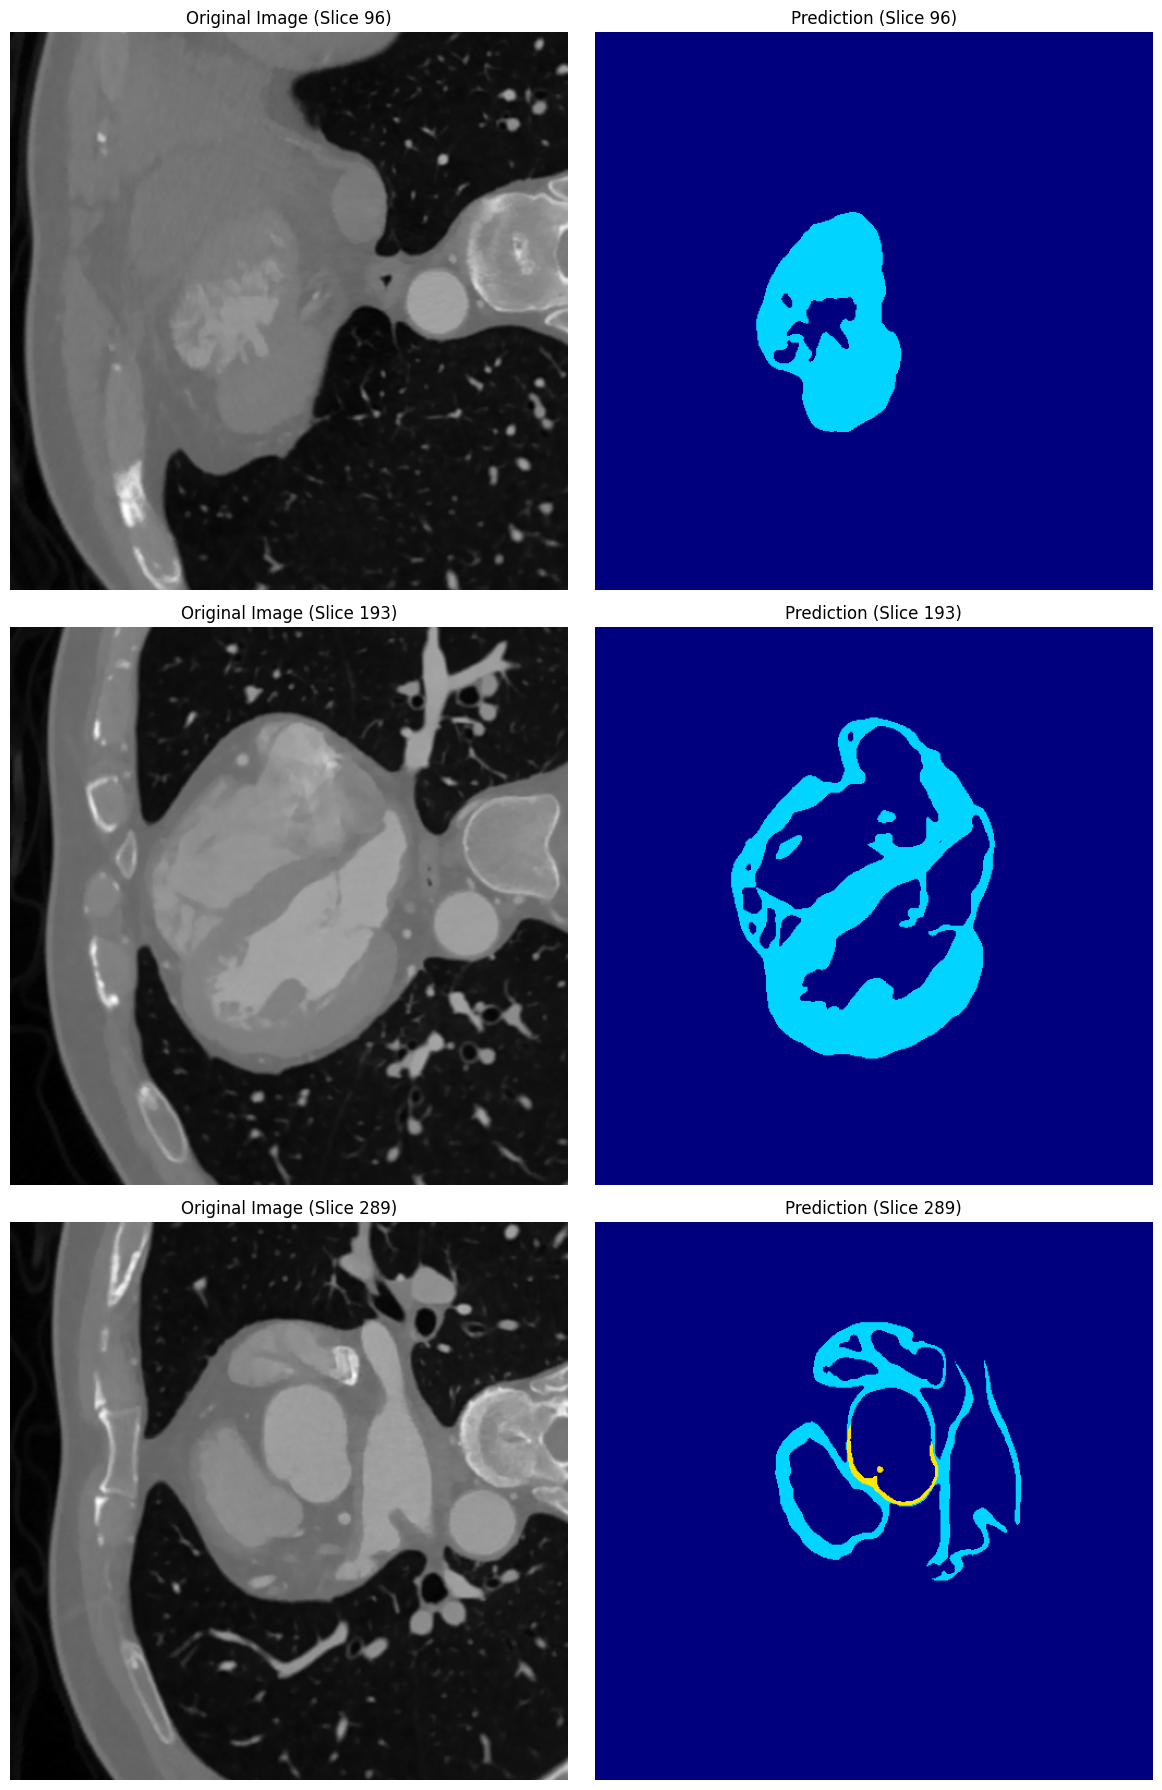

In [12]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt

sample_idx = 0
sample_image_path = test_image_paths[sample_idx]

# 正確處理兩種副檔名：.nii 或 .nii.gz
filename = os.path.basename(sample_image_path)
if filename.endswith('.nii.gz'):
    pred_name = filename.replace('.nii.gz', '_pred.nii.gz')
elif filename.endswith('.nii'):
    pred_name = filename.replace('.nii', '_pred.nii.gz')
else:
    raise ValueError("Unknown file type")

sample_output_path = os.path.join(output_dir, pred_name)

# 讀影像
sample_image = nib.load(sample_image_path).get_fdata()
sample_prediction = nib.load(sample_output_path).get_fdata()

print(f'案例: {filename}')
print(f'影像形狀: {sample_image.shape}')
print(f'預測形狀: {sample_prediction.shape}')
print(f'預測類別: {np.unique(sample_prediction)}')

# 挑三張 slice 可視化
slice_indices = [
    sample_image.shape[-1] // 4,
    sample_image.shape[-1] // 2,
    3 * sample_image.shape[-1] // 4
]

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
for i, slice_idx in enumerate(slice_indices):
    axes[i, 0].imshow(sample_image[:, :, slice_idx], cmap='gray')
    axes[i, 0].set_title(f'Original Image (Slice {slice_idx})')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(sample_prediction[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[i, 1].set_title(f'Prediction (Slice {slice_idx})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig(f'prediction_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
plt.show()


各類別的預測體素數統計:

類別         平均              最小              最大             
------------------------------------------------------------
類別 0     83233052        57926105        108205590      
類別 1     3834097         2226554         5078539        
類別 2     69517           43560           93408          
類別 3     0               0               0              


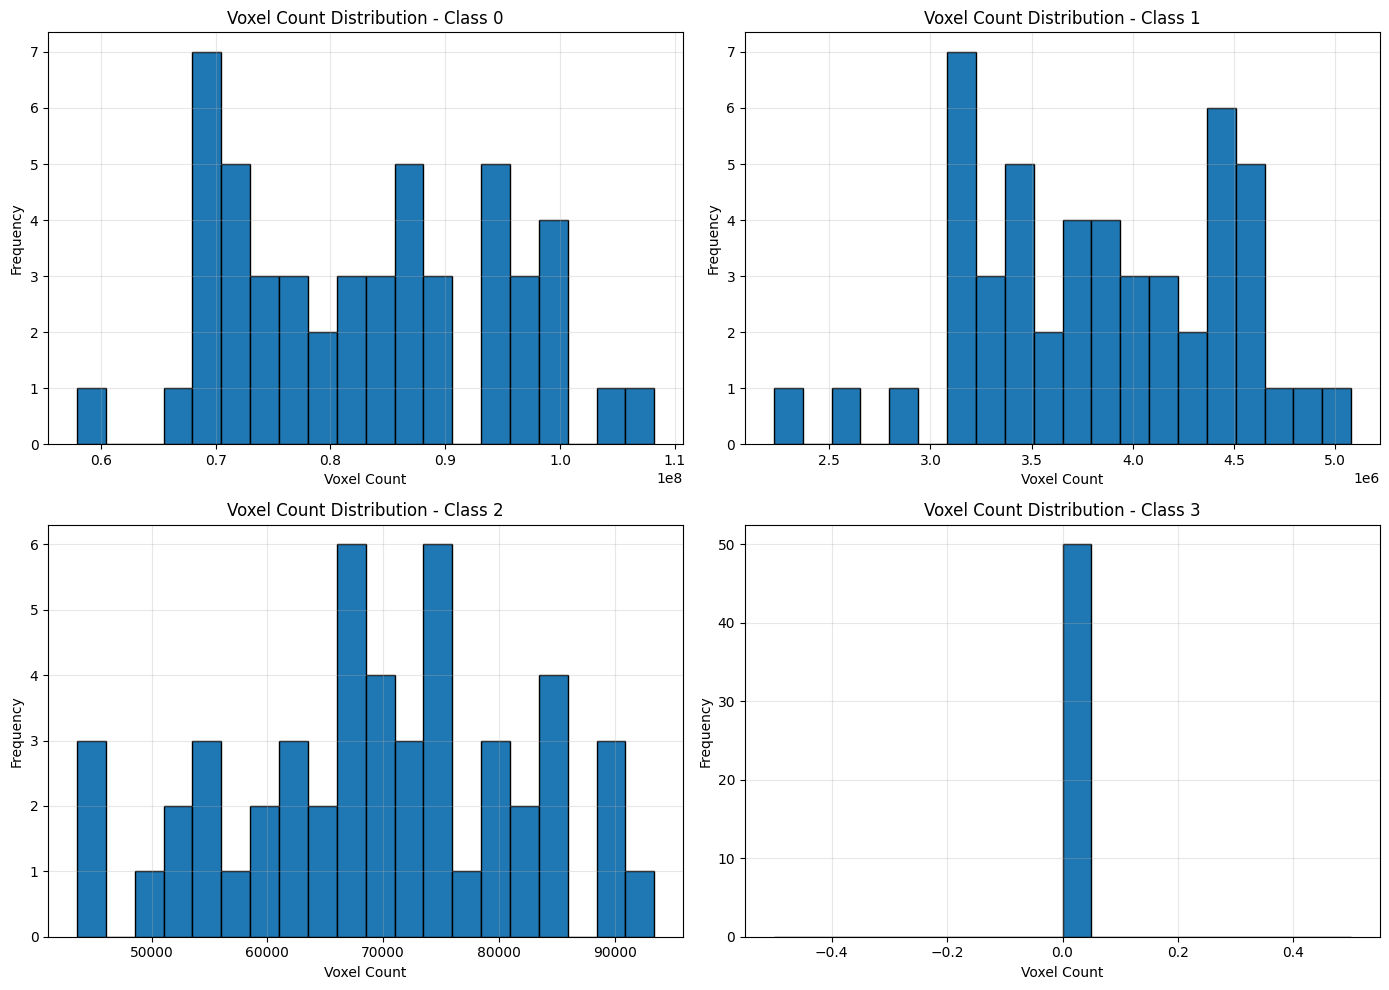


推論完成！共處理 50 個測試影像


In [13]:
# 統計所有預測結果
prediction_files = sorted(glob.glob(os.path.join(output_dir, '*_pred.nii.gz')))

class_counts = {0: [], 1: [], 2: [], 3: []}
for pred_file in prediction_files:
    pred = nib.load(pred_file).get_fdata()
    for class_id in range(4):
        count = np.sum(pred == class_id)
        class_counts[class_id].append(count)

print('各類別的預測體素數統計:\n')
print(f'{"類別":<10} {"平均":<15} {"最小":<15} {"最大":<15}')
print('-' * 60)
for class_id in range(4):
    counts = class_counts[class_id]
    print(f'類別 {class_id:<5} {np.mean(counts):<15.0f} {np.min(counts):<15.0f} {np.max(counts):<15.0f}')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for class_id in range(4):
    axes[class_id].hist(class_counts[class_id], bins=20, edgecolor='black')
    axes[class_id].set_title(f'Voxel Count Distribution - Class {class_id}')
    axes[class_id].set_xlabel('Voxel Count')
    axes[class_id].set_ylabel('Frequency')
    axes[class_id].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\n推論完成！共處理 {len(prediction_files)} 個測試影像')

In [15]:
import zipfile
from datetime import datetime
import os

# 設定雲端硬碟目標資料夾
drive_output_dir = '/content/drive/MyDrive/aicup_data/aicup_results'
os.makedirs(drive_output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = os.path.join(drive_output_dir, f'testing_output_ensemble_{timestamp}.zip')

print(f'正在壓縮預測結果到: {zip_filename}')

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED, compresslevel=6) as zipf:
    pred_files = sorted(glob.glob(os.path.join(output_dir, '*_pred.nii.gz')))
    for pred_file in tqdm(pred_files, desc='壓縮進度'):
        arcname = os.path.basename(pred_file)
        zipf.write(pred_file, arcname=arcname)

print('\n壓縮完成！')
print(f'輸出檔案: {zip_filename}')
print(f'檔案大小: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB')
print(f'包含檔案數: {len(pred_files)}')

正在壓縮預測結果到: /content/drive/MyDrive/aicup_data/aicup_results/testing_output_ensemble_20251126_063849.zip


壓縮進度: 100%|██████████| 50/50 [00:02<00:00, 17.55it/s]


壓縮完成！
輸出檔案: /content/drive/MyDrive/aicup_data/aicup_results/testing_output_ensemble_20251126_063849.zip
檔案大小: 46.91 MB
包含檔案數: 50
